# Bandits

The goal of this problem set is to investigate the behaviour of a multi-armed bandit algorithm in a simple multi-
armed bandit problem.

# Multi-Armed Bandits

## Action Set  
The set of actions is  
$$
A = \{1,2,3,4,5\}
$$

## Environment  
Each action $a \in A$ yields a reward $R_t$ drawn from a Bernoulli distribution $\mathrm{Ber}(p_a)$. In other words:

- If $A_t = a$, then  
  $$
  R_t =
  \begin{cases}
    1 & \text{with probability } p_a \\
    0 & \text{with probability } 1 - p_a
  \end{cases}
  $$
- The true means are:  
  $$
  p_1 = 0.8,\quad p_2 = 0.6,\quad p_3 = 0.5,\quad p_4 = 0.4,\quad p_5 = 0.2
  $$

## Regret  
The expected cumulative regret after $T$ rounds is:
$$
\mathrm{Regret}_T = \mathbb{E}\left[\sum_{t=1}^T \left(p_1 - p_{A_t}\right)\right]
$$

## UCB($\delta$) Algorithm

1. **Counters**  
   $$
   N_t(a) = \sum_{s=1}^t \mathbf{1}\{A_s = a\}
   $$  
   Number of times arm $a$ has been played by round $t$.

2. **Empirical Mean**  
   $$
   \hat{r}_t(a) = \frac{1}{N_t(a)} \sum_{s=1}^t \mathbf{1}\{A_s = a\} R_s
   $$

3. **Upper Confidence Bound**  
   $$
   \mathrm{UCB}_a(t, \delta) =
   \begin{cases}
     \infty & \text{if } N_t(a) = 0 \\
     \hat{r}_t(a) + \sqrt{\frac{\log(1/\delta)}{2N_t(a)}} & \text{otherwise}
   \end{cases}
   $$



### Imports

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

## Setup

First we define a Bandit Arm class which we will use to sample each action's output. 

In [3]:
class BernoulliArm:
    def __init__(self, p):
        self.p = p

    def sample(self):
        return np.random.binomial(1, self.p)

Now we can simply define the function that will execute the UCB algorithm described above

In [4]:
def simulate_bandit(arms, T, delta, best_p, seed=None):
    """
    Run UCB(δ) algorithm for T rounds on the given candidates.

    Arguments:
    - arms: list of BernoulliArm instances
    - T: number of rounds
    - delta: confidence level
    - best_p: true value of the best arm (used for regret calc)

    Returns:
    - cum_regrets: list of cumulative regret values at each step
    - counts: list of how many times each arm was pulled (each action was taken)
    - estimated_means: final reward estimates for each arm
    - final_ucbs: final UCB values for each arm
    """

    if seed is not None:
        np.random.seed(seed)
    

    n_arms = len(arms)
    
    # Initialize list with counts and reward sums for each arm
    # we store them in this way to avoid large memory and computation cost for large T
    counts   = np.zeros(n_arms, int)
    rewards  = np.zeros(n_arms, float)

    # Initialize regrets (including the first n_arms pulls)
    regrets = [best_p - arms[idx].p for idx in range(n_arms)]    

    # Initial pulls for each arm
    for i in range(n_arms):
        score = arms[i].sample()
        counts[i] += 1
        rewards[i] += score
    


    for t in range(n_arms, T):
        ucb_a = [ (rewards[idx] / counts[idx]) + np.sqrt(np.log(1/delta) / (2*counts[idx]))  for idx in range(n_arms)]

        i= np.argmax(ucb_a)
        chosen = arms[i]
        score = chosen.sample()

        # Update counts, rewards and regrets
        counts[i] += 1
        rewards[i] += score
        regrets.append(best_p - chosen.p)
        

    # Calculate cumulative regrets
    cum_regrets = np.cumsum(regrets)

    
    final_ucbs = [(rewards[idx] / counts[idx]) + np.sqrt(np.log(1/delta) / (2*counts[idx])) for idx in range(n_arms)]
    estimated_means = [rewards[idx] / counts[idx] for idx in range(n_arms)]

    return cum_regrets, counts, estimated_means, final_ucbs   

## Part 1: Plotting True Means vs. Final UCBs

In this first experiment, we simulate the UCB($\delta$) algorithm for $T = 10,\!000$ rounds, using a confidence parameter of  
$$
\delta = \frac{1}{T^2}
$$

We apply the algorithm to the Bernoulli bandit setting described earlier, where each arm $a \in \{1, 2, 3, 4, 5\}$ has a known true mean $p_a$.

At the end of the simulation (after all $T$ rounds), we will:
- Plot the **true means** $p_a$ for each arm,
- Plot the corresponding **upper confidence bounds** $\mathrm{UCB}_a(T, \delta)$ computed by the algorithm.

This will help us understand how well the algorithm estimates each arm’s reward, and whether the confidence bounds shrink toward the true means as expected.


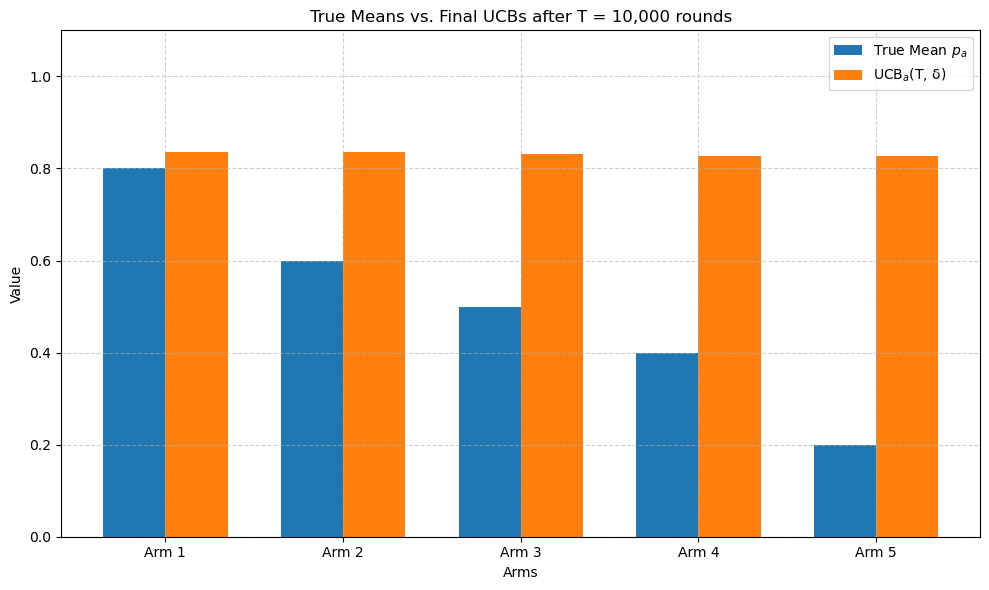

In [7]:
# Initialize arms with different probabilities
arms = [BernoulliArm(p) for p in [0.8, 0.6, 0.5, 0.4, 0.2]]

# Set parameters
T = 1e4  # Total number of rounds
delta = 1 / T**2

# Call the simulation function
cum_regrets, counts, estimated_means, final_ucbs = simulate_bandit(arms, int(T), delta, 0.8, seed=42)


# Extract true means
true_means = [arm.p for arm in arms]
arm_labels = [f"Arm {i+1}" for i in range(len(arms))]

# Create the plot
x = np.arange(len(arms))  # positions for each arm
width = 0.35  # width of each bar

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, true_means, width, label='True Mean $p_a$')
plt.bar(x + width/2, final_ucbs, width, label='UCB$_a$(T, δ)')

# Add labels and title
plt.xlabel("Arms")
plt.ylabel("Value")
plt.title("True Means vs. Final UCBs after T = 10,000 rounds")
plt.xticks(x, arm_labels)
plt.ylim(0, 1.1)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()



### Interpretation

As we know, $ UCB_a $ value represents a balance between the arm's mean reward (observed so far) and an exploration term that favours arms that have been pulled few times. Together, these form an “upper bound” on how good the arm might be. The algorithm always picks the arm with the highest bound. Even if an arm looks bad now, if it hasn’t been tried much, its upper bound might still be high — so it gets a few more chances.

By the end of a long run, the best arm has been pulled a lot so we can assume that $\hat{r}_t(a) \approx 0.8$. Looking at the table above we pbserve how its UCB value is just above 0.8, which indicates that its exploration bonus is small. Sub-optimal arms have lower empirical means, but they were pulled far fewer times, so their exploration bonus is comparatively large. This confidence ( $\delta$) value is just the right fit as to not give too much weight to the exploration term, yet neither prematurely commit to a wrong arm. This means that the algorithm's logic is something like *keep sampling a sub-uptimal arm only until its upper confidence bound drops below that of the best arm*. 


Digging deeper into the UCB formula, we can understand why this is optimal. 

Recall that the UCB value for arm $a$ at time $t$ is: 
$$
   \mathrm{UCB}_a(t, \delta) = \hat{r}_t(a) + \sqrt{\frac{\log(1/\delta)}{2N_t(a)}}
$$
As we know,  **Hoeffding's Inequality** ensures that:
$$ 
\mathrm{UCB}_a(t, \delta) \geq p_a
$$

In other words, the UCB is a valid upper bound on the true mean reward $p_a$ with probability at least $ 1-\delta$. 

If $\mathrm{UCB}_a(t, \delta) \lt p_a$ , we run the risk of prematurely stop exploring arm $a$, despite it actually being good. By always having $\mathrm{UCB}_a(t, \delta) \geq p_a$, we ensure that: 
- The best arm eventually stands out 
- Bad arms get discarded as their UCB's fall below the best arm's mean. 

## Part 2: Investigating the Effect of the Confidence Parameter $\delta$

We already know that the UCB(δ) algorithm is guaranteed to achieve low regret when the confidence parameter is set to  
$
\delta = \frac{1}{T^2}.
$

In this section, we explore how changing the value of δ affects the performance of the algorithm.

To do this, we’ll run the UCB(δ) algorithm for $T = 10,\!000$ rounds using **three different values** of δ:
- $\delta = \frac{1}{T^2}$  (the theoretically recommended setting),
- $\delta = \frac{1}{\sqrt{T}}$  (less cautious — smaller exploration bonus),
- $\delta = \frac{1}{T^{1/20}}$  (very aggressive — minimal exploration bonus).

For each δ:
1. We simulate the UCB algorithm **100 times**,
2. At every time step $t$, we compute the **cumulative regret**:
   $$
   \text{Regret}_t = \sum_{s=1}^t (p_1 - p_{A_s}),
   $$
   where $p_1 = 0.8$ is the true mean of the best arm,
3. We compute the **average cumulative regret** across the 100 runs,
4. Finally, we plot all three curves together to compare the impact of different δ values.

This experiment will help us visualize how sensitive the algorithm is to the choice of δ and understand the tradeoff between **exploration** and **regret minimization**.
